In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

from transformers import BertTokenizer
from torch.utils.data import DataLoader
from datasets import load_from_disk
from tqdm import tqdm

import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from collections import OrderedDict
import pandas as pd

### Data Preparation

In [113]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [114]:
folder_path = '../../../data/seq2seq'
# Load the dataset from disk
seq2seq_dataset = load_from_disk(folder_path)

In [143]:
# train_dataset = seq2seq_dataset['train']
test_dataset = seq2seq_dataset['test']
# val_dataset = seq2seq_dataset['dev']

In [144]:
def tokenize_data(x):
    return {'source': tokenizer(x['source'], padding='max_length'),
            'target': tokenizer(x['target'], padding='max_length')}

In [145]:
# Tokenize the source and target sentences
train_set = train_dataset.map(tokenize_data)
test_set = test_dataset.map(tokenize_data)
val_set = val_dataset.map(tokenize_data)

# Convert the tokenized sentences into tensors and organize them into batches
train_loader = DataLoader(train_set, batch_size=16)
test_loader = DataLoader(test_set)
val_loader = DataLoader(val_set, batch_size=16)

### Implementing Baseline Model - (LSTM seq2seq)

In [119]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        
        output, (hidden, cell) = self.lstm(embedded)
        
        return hidden, cell

In [120]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))
        return prediction, hidden, cell

In [121]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(src)
        
        input = trg[0,:]
        
        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

### Model Initialization

In [122]:
# Define the dimensions
input_dim = len(tokenizer.get_vocab())
output_dim = len(tokenizer.get_vocab())
emb_dim = 256
hid_dim = 512
n_layers = 4
dropout = 0.5

# Initialize the encoder and decoder
enc = Encoder(input_dim, emb_dim, hid_dim, n_layers, dropout)
dec = Decoder(output_dim, emb_dim, hid_dim, n_layers, dropout)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the seq2seq model
model = Seq2Seq(enc, dec, device).to(device)

### Define the Loss Function and Optimizer

In [12]:
# Define the optimizer
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

### Train the Model

In [13]:
GRAD_ACCUM_STEPS = 4  # gradient accumulation steps

# Initialize the gradient scaler for mixed precision training
scaler = GradScaler()

def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()  # reset gradients
    progress_bar = tqdm(iterator, total=len(iterator))
    for i, batch in enumerate(progress_bar):
        src = torch.stack(batch['source']['input_ids']).to(device)
        trg = torch.stack(batch['target']['input_ids']).to(device)
        with autocast():  # mixed precision
            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
        
        # gradient accumulation
        scaler.scale(loss).backward()
        if (i+1) % GRAD_ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        epoch_loss += loss.item()
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
    return epoch_loss / len(iterator)

### Evaluate the Model

In [14]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for _, batch in enumerate(iterator):
            src = torch.stack(batch['source']['input_ids']).to(device)
            trg = torch.stack(batch['target']['input_ids']).to(device)
            output = model(src, trg, 0)  # turn off teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

### Running the Training and Evaluation loop

Let's use 4 GPUs!


Loss: 7.306: 100%|██████████| 3248/3248 [48:18<00:00,  1.12it/s]
/common/home/st1122/.cache/pypoetry/virtualenvs/debiasing-text-with-style-transfer-XprOT1eT-py3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch: 01
	Train Loss: 7.290
	 Val. Loss: 7.212


Loss: 7.222: 100%|██████████| 3248/3248 [48:13<00:00,  1.12it/s]


Epoch: 02
	Train Loss: 7.186
	 Val. Loss: 7.181


Loss: 7.136: 100%|██████████| 3248/3248 [48:13<00:00,  1.12it/s]


Epoch: 03
	Train Loss: 7.040
	 Val. Loss: 7.079


Loss: 7.099: 100%|██████████| 3248/3248 [48:15<00:00,  1.12it/s]


Epoch: 04
	Train Loss: 6.970
	 Val. Loss: 7.086


Loss: 7.056: 100%|██████████| 3248/3248 [48:02<00:00,  1.13it/s]


Epoch: 05
	Train Loss: 6.943
	 Val. Loss: 7.086


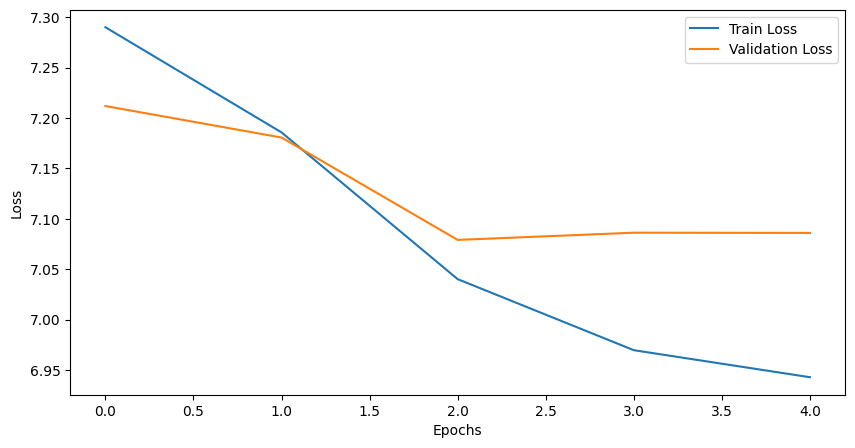

In [15]:
N_EPOCHS = 3
CLIP = 1
SAVE_DIR = '../../../models/baseline-lstm/'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'baseline_model.pt')
PATIENCE = 5  # for early stopping

# Check if multiple GPUs are available and wrap model in DataParallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

best_valid_loss = float('inf')
no_improve_epoch = 0  # count epochs with no improvement

# Lists to store per-epoch loss
train_losses = []
valid_losses = []

# Define the scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)
    
    # Save the losses for this epoch
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Update the learning rate
    scheduler.step()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        no_improve_epoch = 0  # reset count
    else:
        no_improve_epoch += 1
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')
    
    # Early stopping
    if no_improve_epoch >= PATIENCE:
        print("No improvement in validation loss for {} epochs, stopping".format(PATIENCE))
        break

# After all epochs are done, plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the plot
plt.savefig(os.path.join('../../plots/baseline_training_loss.png'))
plt.show()

### Testing the model

In [123]:
def display_output(original_texts, target_texts, generated_texts):
    for i, (source, target, pred) in enumerate(zip(original_texts, target_texts, generated_texts)):
        output = f"\nEXAMPLE {i+1}\n{'-' * 100}\n"
        output += f"{'Source':<10}: {source}\n"
        output += f"{'Target':<10}: {target}\n"
        output += f"{'Predicted':<10}: {pred}\n"
        
        # Split the source and predicted text into words
        source_words = set(source.split())
        pred_words = set(pred.split())

        # Compute the added and removed words
        added = pred_words - source_words
        removed = source_words - pred_words

        # Check if there are any changes
        if not added and not removed:
            output += f"{'CHANGE':<10}: {'No change'}\n"
        else:
            if added:
                output += f"{'ADDED':<10}: {', '.join(added)}\n"
            if removed:
                output += f"{'REMOVED':<10}: {', '.join(removed)}\n"
        output += f"{'-' * 100}"
        print(output)

In [137]:
def test(model, iterator, tokenizer):
    model.eval()
    original_texts = []
    target_texts = []
    generated_texts = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = torch.stack(batch['source']['input_ids']).to(device)
            trg = torch.stack(batch['target']['input_ids']).to(device)
            output = model(src, trg, 0) #turn off teacher forcing
            output_dim = output.shape[-1]
            
            # Take the argmax over the last dimension to get the predicted token at each time step
            top1 = output.argmax(-1)
            
            # Decode the source, target, and predicted sequences
            original_text = tokenizer.decode(src.view(-1).cpu().numpy(), skip_special_tokens=True)
            target_text = tokenizer.decode(trg.view(-1).cpu().numpy(), skip_special_tokens=True)
            generated_text = tokenizer.decode(top1.view(-1).cpu().numpy(), skip_special_tokens=True)
            
            generated_texts.append(generated_text)
            original_texts.append(original_text)
            target_texts.append(target_text)
    return original_texts, target_texts, generated_texts

In [141]:
small_test_dataset = seq2seq_dataset['test'].select(range(10))
small_test_set = small_test_dataset.map(tokenize_data)
small_test_loader = DataLoader(small_test_set)

In [ ]:
# Define the path to the saved model
MODEL_SAVE_PATH = "../../../models/baseline-lstm/baseline_model.pt"

# Load the state dict
state_dict = torch.load(MODEL_SAVE_PATH, map_location=torch.device('cpu'))

# Remove 'module.' prefix
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # remove 'module.' prefix
    new_state_dict[name] = v

# Load the new state dict into the model
model.load_state_dict(new_state_dict)

model.eval()

In [142]:
# Test the model
original_texts, target_texts, generated_texts = test(model, small_test_loader, tokenizer)

# Print the output
display_output(original_texts, target_texts, generated_texts)


EXAMPLE 1
----------------------------------------------------------------------------------------------------
Source    : in april 2009 a brazilian human rights group, torture never again, awarded the five its chico mendes medal, because their rights had been violated.
Target    : in april 2009 a brazilian human rights group, torture never again, awarded the five its chico mendes medal, under the pretext that their rights had been violated.
Predicted : the the is the, the the the the the,,,,,,,,,,,,, the...
ADDED     : the,,,,,,,,,,,,,, the,, is, the...
REMOVED   : awarded, never, had, april, mendes, in, five, torture, their, brazilian, violated., been, 2009, because, a, chico, its, group,, rights, medal,, again,, human
----------------------------------------------------------------------------------------------------

EXAMPLE 2
----------------------------------------------------------------------------------------------------
Source    : the 51 day standoff and ensuing murder of 7

In [146]:
# Test the model
original_texts, target_texts, generated_texts = test(model, test_loader, tokenizer)

In [147]:
# Create a DataFrame and save predictions to CSV
df = pd.DataFrame({
    'source': original_texts,
    'target': target_texts,
    'predicted': generated_texts
})
df.to_csv('../data/baseline_predictions.csv', index=False)